# Business Context

## 1) Business Problem

In this project we seek to help the Blocker Fraud enterprise to detect the fraud transactions.

A empresa vai receber:
The company will receive:
    25% of the value of each transaction truly detected as fraud.
    5% of the value of each transaction detected as fraud, but the transaction is truly legitimate. 

However it returns 100% of the value to the customer, for each transaction detected as legitimate, however the transaction is truly a fraud.

**Main Goal**
Create a tool to help to minize the number of fraud transaction

**Secondary Goal**

- What is the Recall and Precision (Accuracy) of the model?
- What is the confiability of the model in classification as legitmi or fraud ?
- What is the revenue of the company if we classify all the transaction in the data?
- What is the Loss expected if the model fails?
- What is the profit expected to Blocker fraud ?

Business problem: https://sejaumdatascientist.com/crie-uma-solucao-para-fraudes-em-transacoes-financeiras-usando-machine-learning/

Data: https://www.kaggle.com/ntnu-testimon/paysim1

**Estrategia**
-Create a tool to help to minize the number of fraud transaction

Input:
1. Business problema
2. A dataset with 6 milions values

Output:
1. API with a request to predict

Strategy:
1. Data Collect - Download on Kaggle
2. Data Cleaning (finding missing values and outliers, see if some anormaly on the range like negative transactions)
3. Creation of new features.
4. Create business hypotheses
    4.1 - The frequency of the fraud happens more by TRANSFER
    4.2 - The values of Debit are lower than 5000 dolars
    4.3 - TRANSFER has higher values in comparison with the others
    4.4 - Payments of all types are made more in the last 5 days
    4.5 - Days for cash_out is weekly highe
    4.6 - There is a specif hour that happens PAYMENT and TRANSFER
    4.7 - At night has more Fraud transaction
    4.8 - The distribution of fraud amount and non fraud amount is the same
5. Variables Transformations
6. Training Differents models
    6.1 - Baseline with IsolateForest (model to find anomalies)
    6.2 - Logistic Regression
    6.3 - Random Forest
    6.4 - ExtraTree
    6.5 - KNN
7. Model Performance and hypertunning of the best model
8. Business perfomance
9. Report to the Company's CEO with the results
10. Build and Test API


**Index**
0. **Imports and Functions**
1. **Data Description**
2. **Feature Engineering**
3. **Exploratory data analysis**
4. **Data Filter**
5. **Data Preparation**
6. **Feature Selection**
7. **Machine Learning Models**
8. **Hypertunning parameter**
9. **Business translation**
10. **API**

**Models**

1. Isolation Forest
2. Logistic Regression
3. Random Forest
4. Extratree
5. K-NN

**Results**

O melhor resultado foi da random forest porém estava acontecendo o overfiting, dessa forma foi utilizado o segundo modelo que deu o melhor resultado que foi a Extratree.

Como temos que os dados representam do total de Non fraude - 99.9% e Fraude - 0.001%, por isso foi passado para as funções um vetor de balanceamento.

**Answering the CEO's questions**
1. **What is the Recall and Precision (Accuracy) of the model?**

Acuraccy:  0.959148	
Recall:    0.959148	
Precision: 0.998707	
F1-Score:  0.977941

2. **What is the confiability of the model in classification as legitmi or fraud ?**

My model is predicting 96% right non-fraud and 98% fraud.

3. **What is the revenue of the company if we classify all the transaction in the data?**

The revenue of the Blocker Fraud will be R$ 1.23 bilions

4. **What is the Loss expected if the model fails?**

The loss expected is the R$ 3.2 milions	

5. **What is the profit expected to Blocker fraud ?**

The profit of the Blocker Fraud will be R$ 1.22 bilions

# 0.0 Import Packages

In [1]:
import warnings
warnings.filterwarnings

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import seaborn as sns


from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score

from sklearn.model_selection import GridSearchCV

import requests

In [2]:
def cross_val(X,y,model,iter):
    accuracy_EX = []
    recall_EX = []
    precision_EX = []
    f1_EX = []
    kapp_EX = []
    for i in range(0,iter):
        X_tr,X_te,y_tr,y_te = train_test_split(X,y,test_size = 0.3)
        model.fit(X_tr,y_tr)

        y_pre = model.predict(X_te)

        accuracy_EX.append(accuracy_score(y_te, y_pre))
        recall_EX.append(recall_score(y_te, y_pre))
        precision_EX.append(precision_score(y_te, y_pre))
        f1_EX.append(f1_score(y_te, y_pre))
        kapp_EX.append(cohen_kappa_score(y_te, y_pre))

    return [np.mean(accuracy_EX),np.mean(recall_EX),np.mean(precision_EX),np.mean(f1_EX),np.mean(kapp_EX)]

In [3]:
Df_raw = pd.read_csv('Fraud_dataset.csv')

Df_training, Df_validation = train_test_split(Df_raw,test_size=0.25)

# 1.0 Data Description

In [21]:
Df1 = Df_training.copy()
Df1.sample(20)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
4079780,301,PAYMENT,11207.25,C81898956,0.00,0.00,M834881971,0.00,0.00,0,0
1242243,134,PAYMENT,3421.13,C1266810287,0.00,0.00,M380304054,0.00,0.00,0,0
2535784,205,PAYMENT,10367.02,C608882269,13535.97,3168.95,M1314040106,0.00,0.00,0,0
3795141,281,CASH_IN,14776.77,C1069989754,1426043.17,1440819.94,C551519666,185598.50,170821.73,0,0
4526612,326,PAYMENT,1423.84,C1693311963,0.00,0.00,M1158161238,0.00,0.00,0,0
2808781,225,PAYMENT,2920.52,C707273208,56664.00,53743.48,M1621313601,0.00,0.00,0,0
5132545,356,CASH_OUT,51782.94,C178680706,10182.00,0.00,C1203514034,51801.80,103584.74,0,0
4545440,326,CASH_OUT,13497.14,C939675979,0.00,0.00,C706685242,2461213.93,2474711.08,0,0
4570872,327,CASH_IN,254507.14,C1139040466,160826.00,415333.14,C1774959967,4781578.90,4527071.76,0,0
4609385,329,CASH_IN,265704.75,C1212264607,1702099.41,1967804.17,C1639830787,1376969.61,1111264.86,0,0


## 1.1 Columns Name

In [22]:
Df1.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [23]:
Df1 = Df1.rename(columns = {'step':'hour_step','isFraud':'fraud','isFlaggedFraud':'flag_fraud'})

## 1.2 Dimension

In [24]:
print('The number of rows is {}'.format(Df1.shape[0]))
print('The number of cols is {}'.format(Df1.shape[1]))

The number of rows is 4771965
The number of cols is 11


## 1.3 Columns Type

In [25]:
Df1.dtypes

hour_step           int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
fraud               int64
flag_fraud          int64
dtype: object

## 1.4 Missing values

In [26]:
Df1.isna().sum()

hour_step         0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
fraud             0
flag_fraud        0
dtype: int64

## 1.5 Descriptive Statistical

In [27]:
numerical_columns = Df1.select_dtypes(include = ['int64','float64'])

In [28]:
mean = pd.DataFrame(numerical_columns.apply(np.mean)).T
median = pd.DataFrame(numerical_columns.apply(np.median)).T
std = pd.DataFrame(numerical_columns.apply(np.std)).T
minimun = pd.DataFrame(numerical_columns.apply(np.min)).T
maximun = pd.DataFrame(numerical_columns.apply(np.max)).T
amp = pd.DataFrame(numerical_columns.apply(lambda x: x.max() - x.min())).T

skew = pd.DataFrame(numerical_columns.apply(lambda x: x.skew())).T
kurtois =pd.DataFrame(numerical_columns.apply(lambda x: x.kurtosis() )).T

In [29]:
Desc = pd.concat([mean,median,std,minimun,maximun,amp,skew,kurtois]).T.reset_index()

Desc.columns = ['Atribute','mean','median','std','min','max','amplitude','skew','kurtosis']

Desc

,Atribute,mean,median,std,min,max,amplitude,skew,kurtosis
0,hour_step,2.433699e+02,239.00,1.423488e+02,1.0,7.430000e+02,7.420000e+02,0.374937,0.328248
1,amount,1.798384e+05,74938.92,6.010392e+05,0.0,7.382349e+07,7.382349e+07,30.225555,1676.472549
2,oldbalanceOrg,8.339796e+05,14243.00,2.889213e+06,0.0,5.958504e+07,5.958504e+07,5.250796,32.981077
3,newbalanceOrig,8.551846e+05,0.00,2.924998e+06,0.0,4.958504e+07,4.958504e+07,5.178221,32.072071
4,oldbalanceDest,1.101295e+06,132860.38,3.385508e+06,0.0,3.553814e+08,3.553814e+08,19.352906,891.540378
5,newbalanceDest,1.225575e+06,215004.48,3.657047e+06,0.0,3.560159e+08,3.560159e+08,18.744546,803.014704
6,fraud,1.295274e-03,0.00,3.596659e-02,0.0,1.000000e+00,1.000000e+00,27.731561,767.039798
7,flag_fraud,2.724245e-06,0.00,1.650526e-03,0.0,1.000000e+00,1.000000e+00,605.864227,367069.615384


**Overall**


Nenhuma coluna possui valores negativos.

Temos 5 colunas com um valor de Kurtosis muito alto, precisamos investigar para ver oque esta ocasionando isso, muita das vezes é por causa de outliers. Temos que os valores estão bme assimetricos na coluna flag_fraud e no restante temos uma assimetria moderada.

Para as colunas flag_fraud e fraud temos muitos valores que representam não fraude, por isso que tendem a ter skew e kurtosis alta, pois os demais são levados em consideração como outliers (os casos fraudulentos).

Temos uma alta variancia em relação aos valores depositados e os saldos tanto do remetende quanto do destinatario.

Skew é a medida de simentria, ou a falta de simetria
Kurtose é a medide se os dados distribuidos tem um calda longa ou curta relacionado com a normal. Uma kurtoise alta (com calda longa) esta relacionada com outliers

## 1.6 Data Analysis

Analisando visualmente os dados, vemos quando temos o amount (o valor da transação) é maior que o valor em conta, temos que não fica negativo e sim o valor zerado. Vamos criar uma coluna a diferença real entre OldBalanceOrg e amount.Fazendo uma comparação e apagando caso os valores forem distintos

In [30]:
Df1['newbalanceorig_right'] = Df1.apply(lambda x: x['newbalanceOrig'] if x['type'] == 'CASH_IN' else (x['newbalanceOrig'] if x['flag_fraud'] == 1 else x['oldbalanceOrg'] - x['amount']), axis=1)

In [31]:
Comp = Df1['newbalanceorig_right'] == Df1['newbalanceOrig']
uniq = np.unique(Comp, return_counts = True)
one = round((uniq[1][1]/sum(uniq[1]))*100,2)
two = round((uniq[1][0]/sum(uniq[1]))*100,2)
print('A quantidade de valores semelhante foram de {}% e distintos {}%'.format(one,two))

A quantidade de valores semelhante foram de 36.9% e distintos 63.1%


In [32]:
Df1 = Df1.drop('newbalanceOrig', axis = 1)

# 2.0 Feature Engineering

In [33]:
Df2 = Df1.copy()

## 2.1 Hypotesis

**1.** A maioria das fraudes aconteceram por transferencia bancaria

**2.** Os valores de chash_out são inferiores a 5000 reais.

**3.** Transferencias tem valores superiores aos demais

**4.** Pagamentos são feitos mais nos ultimos 5 dias do mes

**5.** Tem horario especificos para transferencias e pagamentos

**6.** Pagamentos são só feitos para lojistas

## 2.2 Feature Creation

In [34]:
Df2['day'] = Df2['hour_step'].apply(lambda x: math.ceil(x/24))

In [35]:
Df2['hour'] = Df2['hour_step'].apply(lambda x: x if x < 24 else x%24 )

# 3.0 Exploratory data analysis

In [36]:
Df3 = Df2.copy()

## 3.1 univariate analysis

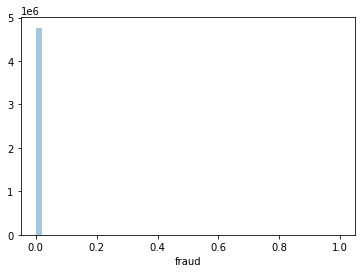

In [44]:
sns.distplot( Df3['fraud'], kde=False  )

### 3.2 Numerical Variable

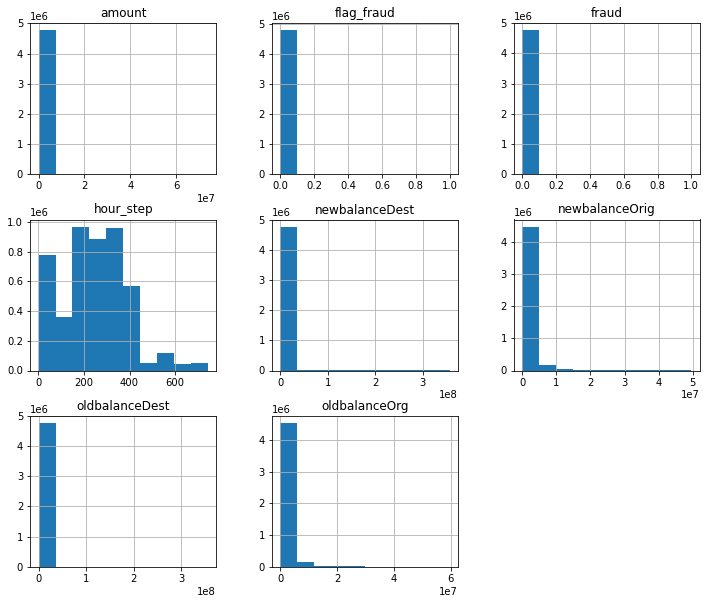

In [63]:
numerical_columns.hist(figsize = (12,10));

### 3.3 Categorical Variable

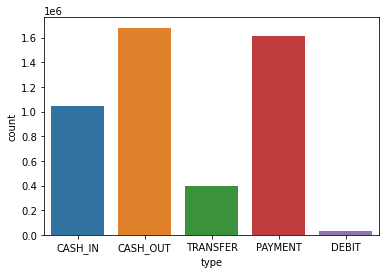

In [65]:
sns.countplot( Df3['type'] )

## 3.2 Bivariate Analysis

### 3.1 - The frequency of the fraud happens more by TRANSFER

**True** - The fraud transaction occours in Transfer and CASH_OUT

In [21]:
Df3[['type','fraud','hour_step']].groupby(['type','fraud']).count()

hour_step
type     fraud           
CASH_IN  0        1049041
CASH_OUT 0        1675362
         1           3074
DEBIT    0          31065
PAYMENT  0        1613703
TRANSFER 0         396647
         1           3073

### 3.2 The values of Debit are lower than 5000 dol.
**False** - Most of the values are between 0 and 10.000

In [22]:
aux = Df3[Df3['type'] == 'DEBIT']

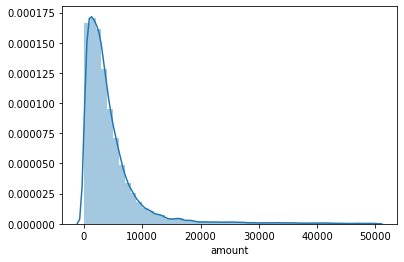

In [23]:
sns.distplot(aux[aux['amount'] < 50000]['amount'])

### 3.3 TRANSFER has higher values in comparison with the others.
**True**

In [18]:
aux = Df3[['type','amount']].groupby('type').mean()
aux

NameError: name 'Df3' is not defined

In [25]:
print('The highest was type {} represent {}% '.format(aux['amount'].idxmax(),round((max(aux['amount'])/sum(aux['amount']))*100,2)))

The highest was type TRANSFER represent 71.5% 


### 3.4 Payments of all types are made more in the last 5 days
**False** The páy more start in the day 6 until 1, maybe they receive their paycheck.

In [26]:
aux = Df3[Df3['type'] == 'PAYMENT']
aux2 = aux[['day','amount']].groupby('day').count()


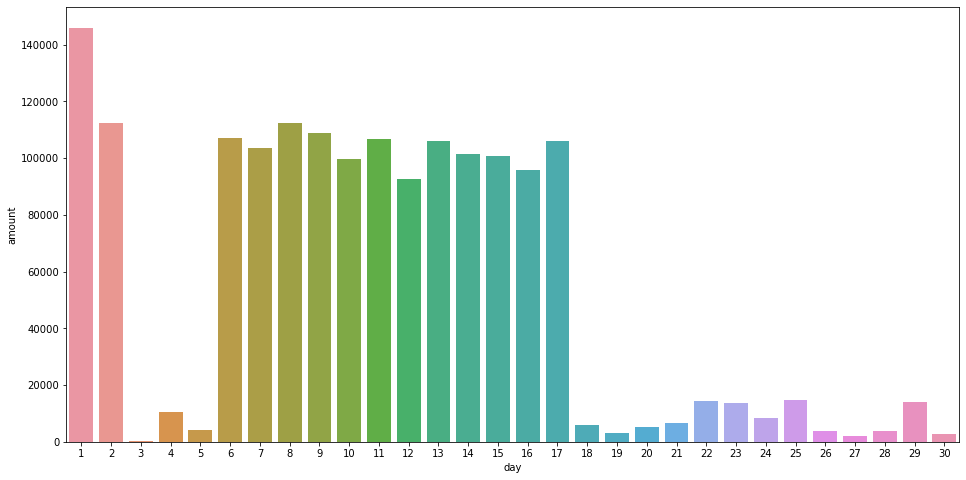

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize = (16,8))
sns.barplot(x = aux2.index, y = aux2['amount'])

### 3.5 Days for cash_out is weekly higher
**False** as the same answer 3.4

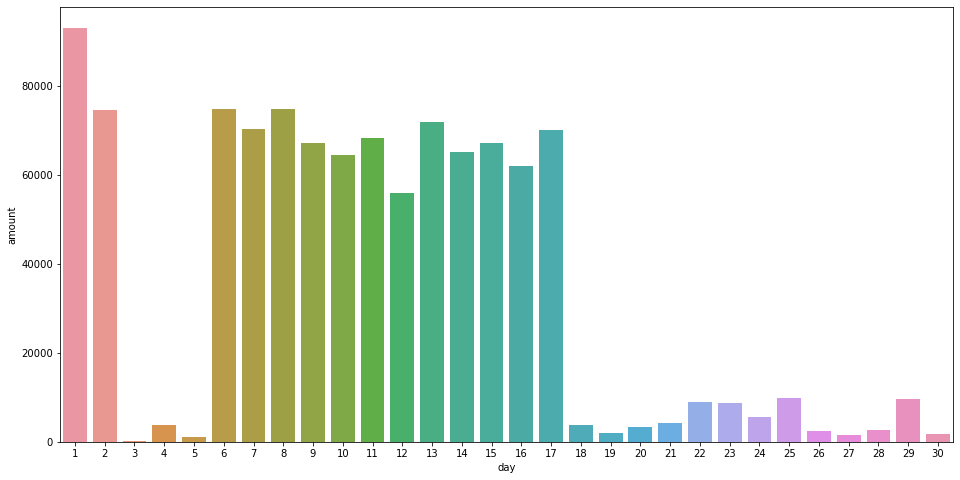

In [28]:
aux = Df3[Df3['type'] == 'CASH_IN']
aux2 = aux[['day','amount']].groupby('day').count()
plt.figure(figsize = (16,8))
sns.barplot(x = aux2.index, y = aux2['amount'])

### 3.6 There is a specif hour that happens PAYMENT and TRANSFER
**True** The transaction starts after 9 and it's more often 18h until 20h

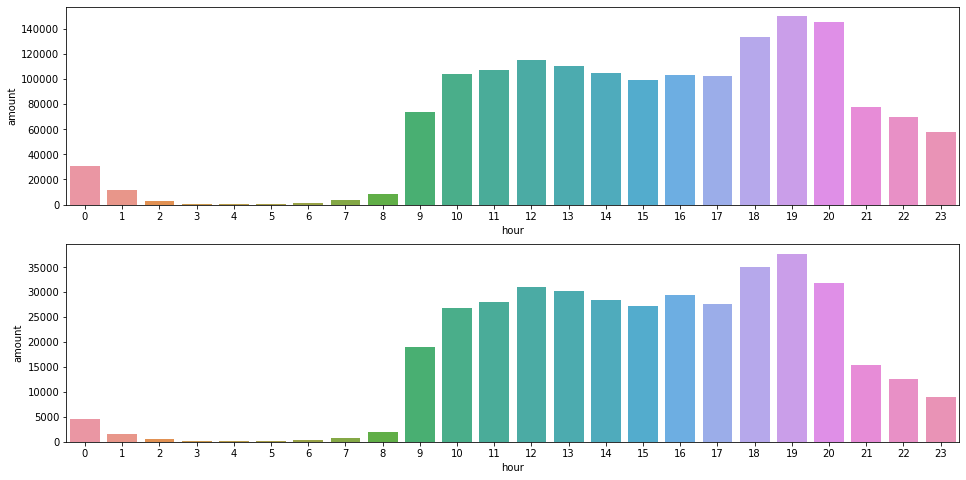

In [29]:
plt.figure(figsize = (16,8))

plt.subplot(2,1,1)
aux = Df3[Df3['type'] == 'PAYMENT']
aux2 = aux[['hour','amount']].groupby('hour').count()
sns.barplot(x = aux2.index, y = aux2['amount'])

plt.subplot(2,1,2)
aux = Df3[Df3['type'] == 'TRANSFER']
aux2 = aux[['hour','amount']].groupby('hour').count()
sns.barplot(x = aux2.index, y = aux2['amount'])

### 3.7 At night has more Fraud transaction
**False** All the fraudulent transactions happens with the same frequency in the time of the day. In the other way a non 
fraudulent transactions start with 9 and end 21h

In [30]:
aux = Df3[Df3['fraud'] == 1]

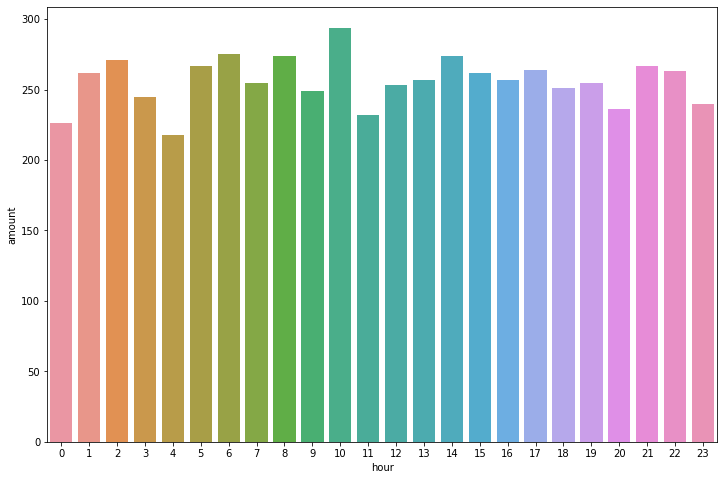

In [31]:
aux2 = aux[['hour','amount']].groupby('hour').count()

plt.figure(figsize = (12,8))
sns.barplot(x = aux2.index, y = aux2['amount'])

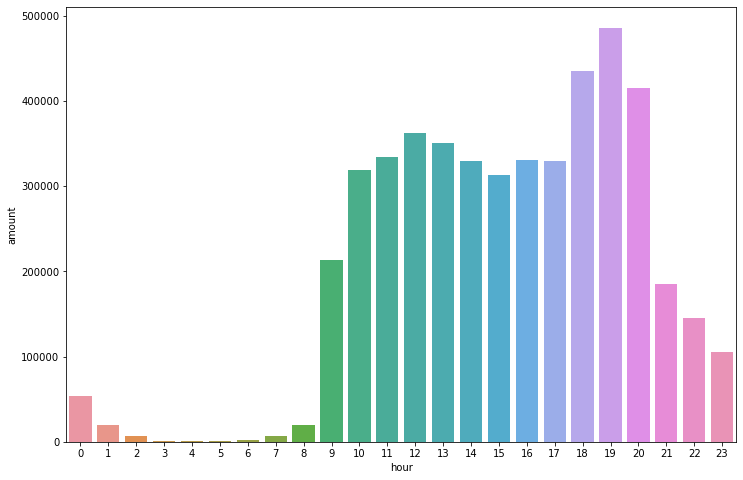

In [32]:
aux3 = Df3[Df3['fraud'] == 0]
aux4 = aux3[['hour','amount']].groupby('hour').count()

plt.figure(figsize = (12,8))
sns.barplot(x = aux4.index, y = aux4['amount'])

### 3.8 The distribution of fraud amount and non fraud amount is the same
**False**

In [33]:
#Testing for normality distribution.
from scipy import stats

shapiro_test_0 = stats.shapiro(aux['amount'])
shapiro_test_1 = stats.shapiro(aux2['amount'])

print(shapiro_test_0)
print(shapiro_test_1)

ShapiroResult(statistic=0.6168115139007568, pvalue=0.0)
ShapiroResult(statistic=0.9768282771110535, pvalue=0.8310193419456482)


D:\Users\gusta\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [34]:
stats.mannwhitneyu(aux['amount'], aux2['amount'])

MannwhitneyuResult(statistic=526.0, pvalue=2.0885974599799713e-17)

In [35]:
shapiro_test_0log = stats.shapiro(np.log1p(aux['amount']))
shapiro_test_1log = stats.shapiro(np.log1p(aux2['amount']))

print(shapiro_test_0log)
print(shapiro_test_1log)

ShapiroResult(statistic=0.9546678066253662, pvalue=5.265252862838711e-40)
ShapiroResult(statistic=0.9691576957702637, pvalue=0.6462246775627136)


In [36]:
stats.mannwhitneyu(np.log1p(aux['amount']), np.log1p(aux2['amount']))

MannwhitneyuResult(statistic=526.0, pvalue=2.0885974599799713e-17)

## 3.3 Multivariate Analysis

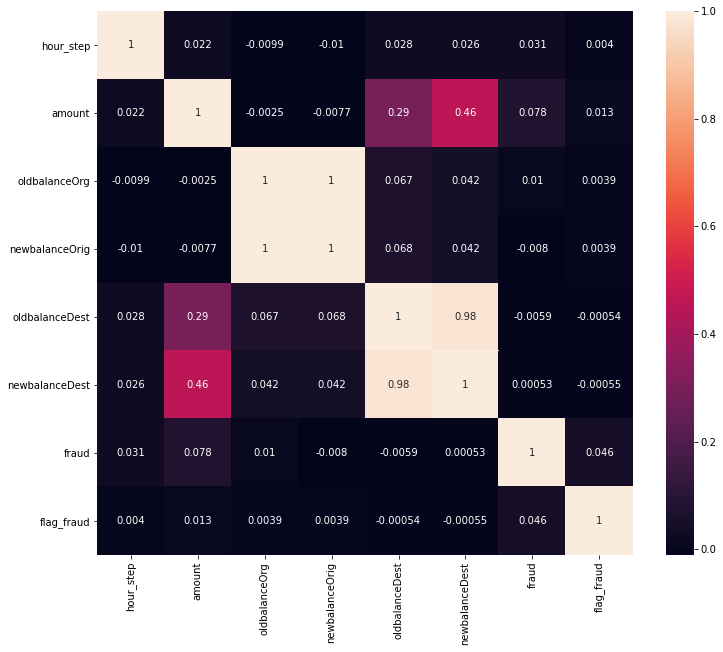

In [42]:
correlation = numerical_columns.corr()
plt.figure(figsize = (12,10))
sns.heatmap( correlation, annot=True );

# 4.0 Data Filters

In [37]:
Df4 = Df3.copy()

In [38]:
#We are going to delete name origin because most of origin is made by a unique person.

In [39]:
tes = Df4[['nameOrig','amount']].groupby('nameOrig').count()
np.unique(tes['amount'], return_counts = True)

(array([1, 2, 3], dtype=int64),
 array([4761588,    5181,       5], dtype=int64))

In [40]:
Df4 = Df4.drop('nameOrig', axis = 1)

In [41]:
#I will try with Merchandts in the nameDest in the next I try withou

# 5.0 Data Transformation

In [42]:
Df5 = Df4.copy()

In [43]:
import pickle

## 5.1 Numerical Transformation

In [44]:
#Amount,OldBalanceOrg,oldBalanceDest,newbalanceDest,newbalanceorig_right

In [45]:
qt = QuantileTransformer()
rs = RobustScaler()
mm = MinMaxScaler()

Df5['amount'] = qt.fit_transform(Df5[['amount']].values)
#pickle.dump(qt, open('parameter/amount_scaler.pkl','wb'))

Df5['oldbalanceOrg'] = qt.fit_transform(Df5[['oldbalanceOrg']].values)
#pickle.dump(qt, open('parameter/oldbalanceOrg_scaler.pkl','wb'))

Df5['oldbalanceDest'] = qt.fit_transform(Df5[['oldbalanceDest']].values)
#pickle.dump(qt, open('parameter/oldbalanceDest_scaler.pkl','wb'))

Df5['newbalanceDest'] = qt.fit_transform(Df5[['newbalanceDest']].values)
#pickle.dump(qt, open('parameter/newbalanceDest_scaler.pkl','wb'))

Df5['newbalanceorig_right'] = rs.fit_transform(Df5[['newbalanceorig_right']].values)
#pickle.dump(rs, open('parameter/newbalanceorig_right_scaler.pkl','wb'))

Df5['hour_step'] = mm.fit_transform(Df5[['hour_step']].values)
#pickle.dump(mm, open('parameter/hour_step_scaler.pkl','wb'))

## 5.2 Categorical Transformation

In [46]:
#One_hot_type = pd.get_dummies(Df5['type'])
#Df5 = pd.concat([Df5,One_hot_type], axis = 1)
#Df5 = Df5.drop('type',axis = 1)

In [47]:
le = LabelEncoder()
Df5['type'] = le.fit_transform(Df5['type'])

#pickle.dump(le, open('parameter/type_scaler.pkl','wb'))

In [48]:
fe = Df5.groupby('nameDest').size()/len(Df5)
Df5.loc[:,'nameDest_encode'] = Df5['nameDest'].map(fe)

In [49]:
Df5

,hour_step,type,amount,oldbalanceOrg,nameDest,oldbalanceDest,newbalanceDest,fraud,flag_fraud,newbalanceorig_right,day,hour,nameDest_encode
1354358,0.183288,0,0.922965,0.938526,C741429346,0.896002,0.866076,0,0,19.632073,6,17,3.352916e-06
4631340,0.442049,3,0.315859,0.000000,M313779228,0.000000,0.000000,0,0,-0.054953,14,17,2.095573e-07
3928249,0.382749,0,0.415621,0.362310,C15944074,0.000000,0.000000,0,0,0.182313,12,21,2.095573e-07
1801239,0.216981,3,0.352511,0.554738,M791106392,0.000000,0.000000,0,0,0.005961,7,18,2.095573e-07
5157809,0.479784,4,0.892428,0.496169,C381496133,0.000000,0.564994,0,0,-1.296688,15,21,4.191146e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...
329287,0.020216,3,0.263557,0.778015,M827370978,0.000000,0.000000,0,0,0.543922,1,16,2.095573e-07
1213844,0.177898,0,0.132189,0.978504,C430101713,0.554348,0.514161,0,0,39.142847,6,13,3.143359e-06
1523564,0.204852,0,0.816723,0.884708,C1153280680,0.631518,0.480412,0,0,5.015990,7,9,2.305130e-06
4396478,0.431267,3,0.274036,0.399427,M1028895919,0.000000,0.000000,0,0,-0.029770,14,9,2.095573e-07


## 5.3 Cycle Transformation

In [50]:
Df5['day_sin'] = Df5['day'].apply(lambda x: np.sin(x*(2. * np.pi/31)))
Df5['day_cos'] = Df5['day'].apply(lambda x: np.cos(x*(2. * np.pi/31)))

Df5['hour_sin'] = Df5['hour'].apply(lambda x: np.sin(x*(2. * np.pi/24)))
Df5['hour_cos'] = Df5['hour'].apply(lambda x: np.cos(x*(2. * np.pi/24)))

# 6.0 Variable Selection

In [51]:
Df6 = Df5.copy()

## 6.1 Splitting the data 

In [52]:
cols_drop = ['day','hour','nameDest']

Df6 = Df6.drop(cols_drop, axis = 1)

In [53]:
y = Df6['fraud']

X_train,X_test,y_train,y_test = train_test_split(Df6.drop('fraud',axis = 1),y,test_size = 0.3)

## 6.2 Boruta Selector

In [37]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

In [38]:
X_train_n = X_train.values
y_train_n = y_train.values.ravel()
#define RandomFOrestRegressor
rf = RandomForestRegressor(n_jobs = -1)
#define Boruta
boruta = BorutaPy(rf,n_estimators = 'auto', verbose = 2, random_state = 42).fit(X_train_n,y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	14
Tentative: 	0
Rejected: 	3


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	14
Tentative: 	0
Rejected: 	3


In [39]:
cols_selects = boruta.support_.tolist()

X_train_fs = X_train

cols_selected_boruta = X_train_fs.iloc[:,cols_selects].columns.to_list()

#not selected boruta
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns,cols_selected_boruta))

In [40]:
cols_selected_boruta

['hour_step',
 'amount',
 'oldbalanceOrg',
 'oldbalanceDest',
 'newbalanceDest',
 'newbalanceorig_right',
 'CASH_IN',
 'CASH_OUT',
 'TRANSFER',
 'nameDest_encode',
 'day_sin',
 'day_cos',
 'hour_sin',
 'hour_cos']

## 6.3 Features

In [54]:
cols_selected_boruta = [
    'hour_step',
 'type',
 'amount',
 'oldbalanceOrg',
 'oldbalanceDest',
 'newbalanceDest',
 'newbalanceorig_right',
 'nameDest_encode',
 'day_sin',
 'day_cos',
 'hour_sin'
]

# 7.0 Machine Learning Model

-Logistic Regression
-Random Forest
-Xtress
-Neural Network


In [55]:
X_train_fs = X_train[cols_selected_boruta]
X_test_fs = X_test[cols_selected_boruta]

In [56]:
cla1 = len(y_train[y_train == 1])/len(y_train)
cla0 = len(y_train[y_train == 0])/len(y_train)

In [57]:
cla0+0.0004

0.9991043370879018

In [58]:
cla_wig = {0:cla1-0.0004,1:cla0+0.0004}

## 7.1 BaseLine with IsolationForest

<font size = 6> IsolationForest </font>
    
It's an unsupervised learning algorithm that identifies anomaly by isolating outliers in the data.

Isolation Forest is based on the Decision Tree algorithm. It isolates the outliers by randomly selecting a feature from the given set of features and then randomly selecting a split value between the max and min values of that feature. This random partitioning of features will produce shorter paths in trees for the anomalous data points, thus distinguishing them from the rest of the data.

The Isolation Forest algorithm is based on the principle that anomalies are observations that are few and different, which should make them easier to identify. Isolation Forest uses an ensemble of Isolation Trees for the given data points to isolate anomalies.

Isolation Forest recursively generates partitions on the dataset by randomly selecting a feature and then randomly selecting a split value for the feature. Presumably the anomalies need fewer random partitions to be isolated compared to "normal" points in the dataset, so the anomalies will be the points which have a smaller path length in the tree, path length being the number of edges traversed from the root node.

**Using Isolation Forest, we can not only detect anomalies faster but we also require less memory compared to other algorithms. As anomalies data points mostly have a lot shorter tree paths than the normal data points, trees in the isolation forest does not need to have a large depth so a smaller max_depth can be used resulting in low memory requirement.**

For more information of the mathematic part read: https://medium.com/@hyunsukim_9320/isolation-forest-step-by-step-341b82923168

In [45]:
IF = IsolationForest(n_jobs = -1,bootstrap = True).fit(X_test_fs)

In [46]:
y_predict_Base = IF.predict(X_test_fs)

In [47]:
y_predict_Base[y_predict_Base == 1] = 0
y_predict_Base[y_predict_Base == -1] = 1

In [48]:
confusion_matrix(y_test, y_predict_Base)

array([[808492, 621246],
       [   117,   1735]], dtype=int64)

In [70]:
accuracy_base = accuracy_score(y_test, y_predict_Base)
recall_base = recall_score(y_test, y_predict_Base,average = 'weighted')
precision_base = precision_score(y_test, y_predict_Base,average = 'weighted')
f1_base = f1_score(y_test, y_predict_Base,average = 'weighted')
kapp_base = cohen_kappa_score(y_test, y_predict_Base)

In [71]:
metrics_base = [accuracy_base,recall_base,precision_base,f1_base,kapp_base]
metrics_base

[0.5659630201384475,
 0.5659630201384476,
 0.9985654306352084,
 0.7214735888035855,
 0.002981511056737496]

## 7.2 Logistic Regression

In [51]:
LR = LogisticRegression(class_weight = cla_wig)
LR.fit(X_train_fs,y_train)

LogisticRegression(class_weight={0: 0.0008890768252067507,
                                 1: 0.9991109231747932})

In [52]:
y_predict_LR = LR.predict(X_test_fs)

In [53]:
confusion_matrix(y_test, y_predict_LR)

array([[1288313,  141425],
       [     43,    1809]], dtype=int64)

In [72]:
accuracy_LR = accuracy_score(y_test, y_predict_LR)
recall_LR = recall_score(y_test, y_predict_LR,average = 'weighted')
precision_LR = precision_score(y_test, y_predict_LR,average = 'weighted')
f1_LR = f1_score(y_test, y_predict_LR,average = 'weighted')
kapp_LR = cohen_kappa_score(y_test, y_predict_LR)

In [73]:
metrics_LR = [accuracy_LR,recall_LR,precision_LR,f1_LR,kapp_LR]
metrics_LR

[0.9011812041157036,
 0.9011812041157036,
 0.99868933942381,
 0.9467591596255795,
 0.02243994638102975]

## 7.3 Random Forest

In [56]:
RF = RandomForestClassifier(random_state = 42, n_jobs = -1, class_weight = cla_wig)
RF.fit(X_train_fs,y_train)
y_predict_RF = RF.predict(X_test_fs)

In [57]:
confusion_matrix(y_test, y_predict_RF)

array([[1429737,       1],
       [      6,    1846]], dtype=int64)

In [74]:
accuracy_RF = accuracy_score(y_test, y_predict_RF)
recall_RF = recall_score(y_test, y_predict_RF,average = 'weighted')
precision_RF = precision_score(y_test, y_predict_RF,average = 'weighted')
f1_RF = f1_score(y_test, y_predict_RF,average = 'weighted')
kapp_RF = cohen_kappa_score(y_test, y_predict_RF)

In [75]:
metrics_RF = [accuracy_RF,recall_RF,precision_RF,f1_RF,kapp_RF]

## 7.4E XTree

ExtraTree is a model that works the same as Random Forest, with a few differences, is also a ensemble method using differents decision tree (using sum or votting to make the predition).

ExtraTree create differents decision tree using all the training, for Random Forest to train the decision Tree they use a random subsample (with replacement).  Another difference is ExtraTree randomly choose the features they are going to use to split the tree, meanwhile random forest randomly the features but find the best split of the features for the decision tree.

When we use the all data, in the case of ExtraTree, will reduce the bias and randomly choosing the features reduce the variance of our model. ExtraTree is a faster model than Random Forest because don't have to calculate the optimal cut.

In [60]:
EX = ExtraTreesClassifier(random_state = 42, n_jobs = -1, class_weight = cla_wig)
EX.fit(X_train_fs,y_train)
y_predict_EX = EX.predict(X_test_fs)

In [61]:
confusion_matrix(y_test, y_predict_EX)

array([[1429726,      12],
       [    348,    1504]], dtype=int64)

In [76]:
accuracy_EX = accuracy_score(y_test, y_predict_EX)
recall_EX = recall_score(y_test, y_predict_EX,average = 'weighted')
precision_EX = precision_score(y_test, y_predict_EX,average = 'weighted')
f1_EX = f1_score(y_test, y_predict_EX,average = 'weighted')
kapp_EX = cohen_kappa_score(y_test, y_predict_EX)

In [77]:
metrics_EX = [accuracy_EX,recall_EX,precision_EX,f1_EX,kapp_EX]

## 7.5 KNN

In [64]:
KNN = KNeighborsClassifier(n_neighbors=2, n_jobs = -1)
KNN.fit(X_train_fs,y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=2)

In [65]:
y_predict_KNN = KNN.predict(X_test_fs)
confusion_matrix(y_test, y_predict_KNN)

array([[1429719,      19],
       [    524,    1328]], dtype=int64)

In [78]:
accuracy_KNN = accuracy_score(y_test, y_predict_KNN)
recall_KNN = recall_score(y_test, y_predict_KNN,average = 'weighted')
precision_KNN = precision_score(y_test, y_predict_KNN,average = 'weighted')
f1_KNN = f1_score(y_test, y_predict_KNN,average = 'weighted')
kapp_KNN = cohen_kappa_score(y_test, y_predict_KNN)

In [79]:
metrics_KNN = [accuracy_KNN,recall_KNN,precision_KNN,f1_KNN,kapp_KNN]

## 7.6 Model's Performance

In [80]:
dic = {'BaseLine':metrics_base,'Logistic Rregression':metrics_LR,'Random Forest':metrics_RF,'EX Three':metrics_EX,'KNN':metrics_KNN}
Performance = pd.DataFrame(dic).T
Performance = Performance.rename(columns = {0:'Accuracy',1:'Recall',2:'Precision',3:'F1-Score',4:'Kappa Score'})

In [81]:
Performance

,Accuracy,Recall,Precision,F1-Score,Kappa Score
BaseLine,0.565963,0.565963,0.998565,0.721474,0.002982
Logistic Rregression,0.901181,0.901181,0.998689,0.946759,0.022440
Random Forest,0.999995,0.999995,0.999995,0.999995,0.998105
EX Three,0.999749,0.999749,0.999747,0.999736,0.892987
KNN,0.999621,0.999621,0.999616,0.999591,0.830074


# 8.0 Hyperparameter Fine Tuning

## 8.1 Tunning Logistic Regression

In [82]:
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l1', 'l2']
c_values = [100, 10, 1.0, 0.1, 0.01,0.001]
grid = dict(solver=solvers,penalty=penalty,C=c_values)
model_LR = LogisticRegression(class_weight = cla_wig)
grid_search_LR = GridSearchCV(estimator=model_LR, param_grid=grid, n_jobs=-1, cv=5, scoring='accuracy')

In [83]:
results_LR = grid_search_LR.fit(X_train_fs,y_train)

D:\Users\gusta\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [125]:
results_LR.best_estimator_

LogisticRegression(C=100,
                   class_weight={0: 0.000881592635557385,
                                 1: 0.9991184073644426},
                   solver='newton-cg')

In [86]:
accuracy_LR = accuracy_score(y_test, y_predict_LR)
recall_LR = recall_score(y_test, y_predict_LR)
precision_LR = precision_score(y_test, y_predict_LR)
f1_LR = f1_score(y_test, y_predict_LR)
kapp_LR = cohen_kappa_score(y_test, y_predict_LR)
metrics_LR = [accuracy_LR,recall_LR,precision_LR,f1_LR,kapp_LR]
Per_LR = pd.DataFrame(metrics_LR).T
Per_LR = Per_LR.rename(columns = {0:'Accuracy',1:'Recall',2:'Precision',3:'F1-Score',4:'Kappa Score'})
Per_LR

,Accuracy,Recall,Precision,F1-Score,Kappa Score
0,0.917185,0.978942,0.015067,0.029677,0.027198


In [126]:
LR = LogisticRegression(class_weight = cla_wig,penalty = 'l2',solver = 'newton-cg',C =100)
LR.fit(X_train_fs,y_train)

LogisticRegression(C=100,
                   class_weight={0: 0.000881592635557385,
                                 1: 0.9991184073644426},
                   solver='newton-cg')

In [127]:
y_predict_LR = LR.predict(X_test_fs)
confusion_matrix(y_test, y_predict_LR)

array([[1207246,  222436],
       [    215,    1693]], dtype=int64)

In [128]:
accuracy_LR = accuracy_score(y_test, y_predict_LR)
recall_LR = recall_score(y_test, y_predict_LR)
precision_LR = precision_score(y_test, y_predict_LR)
f1_LR = f1_score(y_test, y_predict_LR)
kapp_LR = cohen_kappa_score(y_test, y_predict_LR)
metrics_LR = [accuracy_LR,recall_LR,precision_LR,f1_LR,kapp_LR]

In [129]:
Per_LR = pd.DataFrame(metrics_LR).T
Per_LR = Per_LR.rename(columns = {0:'Accuracy',1:'Recall',2:'Precision',3:'F1-Score',4:'Kappa Score'})
Per_LR

,Accuracy,Recall,Precision,F1-Score,Kappa Score
0,0.844473,0.887317,0.007554,0.01498,0.012369


## 8.2 Tunning ExtraTrees

In [87]:
n_estimator = [100]
max_depths = [1,2,5,7,10,12]
min_samples_splits = [2,4,5,7,10]
min_samples_leafs = [1,2,3,4,5]
max_feature = ['auto','sqrt','log2']
grid_EX = dict(n_estimators = n_estimator,max_depth= max_depths,min_samples_split= min_samples_splits,min_samples_leaf = min_samples_leafs,max_features = max_feature)

In [88]:
import random
final_result = pd.DataFrame()
MAX_EVAL = 20
for i in range(MAX_EVAL):
    ##choose values for parameters randomly
    hp = {k : random.sample(v,1)[0] for k , v in grid_EX.items() }
    print(hp)
    model = ExtraTreesClassifier(random_state = 42, n_jobs = -1, class_weight = cla_wig,
                                max_depth = hp['max_depth'],
                                min_samples_split = hp['min_samples_split'],
                                min_samples_leaf = hp['min_samples_leaf'],
                                max_features = hp['max_features'])
    
    result = cross_val(X_train_fs,y_train,model,10)
    result_pd = pd.DataFrame(result).T
    final_result = pd.concat([final_result,result_pd])
    #model

{'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt'}
{'n_estimators': 100, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'auto'}
{'n_estimators': 100, 'max_depth': 1, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}
{'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'auto'}
{'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'log2'}
{'n_estimators': 100, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt'}
{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2'}
{'n_estimators': 100, 'max_depth': 1, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'auto'}
{'n_estimators': 100, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'auto'}
{'n_estimators'

In [63]:
final_result = final_result.rename(columns = {0:'Accuracy',1:'Recall',2:'Precision',3:'F1-Score',4:'Kappa Score'})

In [64]:
final_result

,Accuracy,Recall,Precision,F1-Score,Kappa Score
0,0.399891,0.980563,0.002159,0.004309,0.001672
0,0.394406,0.981011,0.002113,0.004216,0.001614
0,0.397241,0.981010,0.002133,0.004256,0.001641
0,0.948568,0.959273,0.024080,0.046974,0.044522
0,0.918656,0.956295,0.015187,0.029899,0.027392
0,0.394880,0.981740,0.002125,0.004241,0.001627
0,0.727356,0.952596,0.004530,0.009018,0.006444
0,0.947687,0.964219,0.023340,0.045575,0.043159
0,0.399731,0.980020,0.002157,0.004305,0.001669
0,0.395380,0.981603,0.002123,0.004237,0.001628


## 8.3 Final Parameters for ExtraTrees

{'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'sqrt'}

In [59]:
EX = ExtraTreesClassifier(random_state = 42, n_jobs = -1, class_weight = cla_wig,
                         max_depth = 10,
                         min_samples_split = 4,
                         min_samples_leaf = 5,
                         max_features = 'sqrt')
EX.fit(X_train_fs,y_train)
y_predict_final = EX.predict(X_test_fs)

In [60]:
confusion_matrix(y_test, y_predict_final)

array([[1371487,   58284],
       [     44,    1775]], dtype=int64)

# 9.0 Bussiness

## 9.1 Model reliability

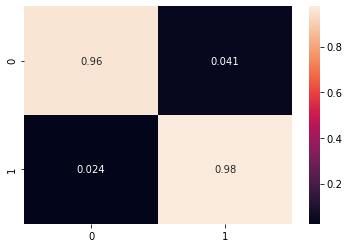

In [61]:
conf = confusion_matrix(y_test, y_predict_final,normalize = 'true')
sns.heatmap(conf, annot = True)

In [62]:
from sklearn.metrics import balanced_accuracy_score

#accuracy_EX = balanced_accuracy_score(y_test, y_predict_final)
accuracy_EX  = accuracy_score(y_test, y_predict_final)
recall_EX = recall_score(y_test, y_predict_final,average = 'weighted')
precision_EX = precision_score(y_test, y_predict_final,average = 'weighted')
f1_EX = f1_score(y_test, y_predict_final,average = 'weighted')
kapp_EX = cohen_kappa_score(y_test, y_predict_final,)
metrics_EX = [accuracy_EX,recall_EX,precision_EX,f1_EX,kapp_EX]

Metrics = pd.DataFrame(metrics_EX).T
Metrics = Metrics.rename(columns = {0:'Accuracy',1:'Recall',2:'Precision',3:'F1-Score',4:'Kappa Score'})
Metrics

,Accuracy,Recall,Precision,F1-Score,Kappa Score
0,0.959256,0.959256,0.998735,0.978007,0.05504


<font size = 4> **Conclusion** </font>

Looking only for the fraud transaction our model has good 98% of accuracy but for non fraud our model is lower with 96%. The initial idea was to create a good model to predict fraud transaction, our model is doing well.

For the next steps is to increase the accuracy of non fraud transaction and the same time maintain the the precision of fraud.

## 9.2 Revenues

<font size = 4> **Conclusion** </font>


It is possible to notice that the values of the transitions in which our model was unable to classify correctly were between 0 - 100 thousand. And the other hand the value of the transaction for right classify was 0.5 - 1 milions dolars.

In [63]:
ind_tes = X_test_fs.index

In [64]:
Df9 = Df4.loc[ind_tes]
#Df9['fraud'] = y_test
Df9['prediction'] = y_predict_final

In [65]:
value = []
for i in range(0, len(Df9)):
    if (Df9['fraud'].values[i] == 1) & (Df9['prediction'].values[i] == 1):
        value.append(round(Df9['amount'].values[i]*0.25,2))
    elif (Df9['fraud'].values[i] == 0) & (Df9['prediction'].values[i] == 1):
        value.append(round(Df9['amount'].values[i]*0.05,2))
    elif (Df9['fraud'].values[i] == 1) & (Df9['prediction'].values[i] == 0):
        value.append(-round(Df9['amount'].values[i],2))
    elif (Df9['fraud'].values[i] == 0) & (Df9['prediction'].values[i] == 0):
        value.append(0)

In [66]:
Df9['receive_value'] = value

### 9.2.1 Distribution of Negative Revenue

In [67]:
Lost = Df9[(Df9['fraud'] == 1) & (Df9['prediction'] == 0)]

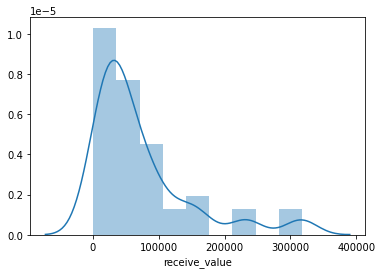

In [68]:
sns.distplot(-Lost['receive_value'])

### 9.2.2 Distribution of Positive Revenue

In [69]:
Win1 = Df9[(Df9['fraud'] == 0) & (Df9['prediction'] == 1)]
Win2 = Df9[(Df9['fraud'] == 1) & (Df9['prediction'] == 1)]

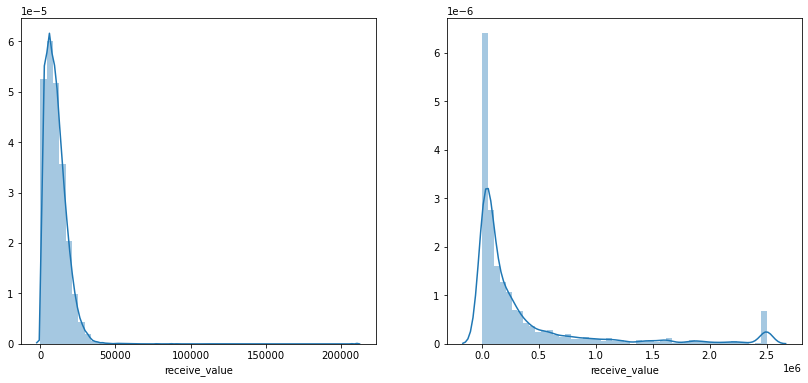

In [70]:
plt.figure(figsize = (14,6))

plt.subplot(1,2,1)
sns.distplot(Win1['receive_value']);

plt.subplot(1,2,2)
sns.distplot(Win2['receive_value']);

## 9.3 Performance

In [71]:
Negative_values = Df9[Df9['receive_value'] < 0]
Null_values = Df9[Df9['receive_value'] == 0]
Positve_values = Df9[Df9['receive_value'] > 0]

In [72]:
count = [Negative_values.shape[0],Null_values.shape[0],Positve_values.shape[0]]
sums = [Negative_values['receive_value'].sum(),Null_values['receive_value'].sum(),Positve_values['receive_value'].sum()]
Amount = [Negative_values['amount'].sum(),Null_values['amount'].sum(),Positve_values['amount'].sum()]

dictna = {'Quantidade':count,'Receita':sums,'Soma das Transferencia':Amount}
Final = pd.DataFrame(dictna)
Final.index = ['Fraudes não classificadas','Non-Fraudes certas','Classificacao corretas']

In [73]:
Final.index = ['Fraudes não classificadas','Non-Fraudes certas','Classificacao corretas']

In [74]:
Final

,Quantidade,Receita,Soma das Transferencia
Fraudes não classificadas,43,-3.183506e+06,3.183506e+06
Non-Fraudes certas,1371488,0.000000e+00,2.439496e+11
Classificacao corretas,60059,1.233141e+09,1.432928e+10


In [75]:
Revenue_final = Final['Receita'].sum()
Percentage_of = round((Revenue_final/Final['Soma das Transferencia'].sum())*100,2)

In [76]:
print('The company will receive ${} that represent {}% of the all transactions.'.format(round(Revenue_final,2),Percentage_of))

The company will receive $1229957089.67 that represent 0.48% of the all transactions.


# 10.0 API

In [109]:
import pickle
import pandas as pd
import numpy as np
import math
import datetime

class Fraud ( object ):
    def __init__(self):
        self.home_path = 'D:/DataZero/Detecção_fraude/'
        self.amount_scaler       = pickle.load(open(self.home_path + 'parameter/amount_scaler.pkl','rb'))
        self.oldbalanceOrg_scaler           = pickle.load(open(self.home_path + 'parameter/oldbalanceOrg_scaler.pkl','rb'))
        self.oldbalanceDest_scaler = pickle.load(open(self.home_path + 'parameter/oldbalanceDest_scaler.pkl','rb'))
        self.newbalanceDest_scaler       = pickle.load(open(self.home_path + 'parameter/newbalanceDest_scaler.pkl','rb'))
        self.newbalanceorig_right_scaler           = pickle.load(open(self.home_path + 'parameter/newbalanceorig_right_scaler.pkl','rb'))
        self.hour_step_scaler = pickle.load(open(self.home_path + 'parameter/hour_step_scaler.pkl','rb'))
        self.type_scaler = pickle.load(open(self.home_path + 'parameter/type_scaler.pkl','rb'))    

    def data_cleaning(self,df1):
        df1 = df1.rename(columns = {'step':'hour_step','isFraud':'fraud','isFlaggedFraud':'flag_fraud'})

        df1['newbalanceorig_right'] = df1.apply(lambda x: x['newbalanceOrig'] if x['type'] == 'CASH_IN' else (x['newbalanceOrig'] if x['flag_fraud'] == 1 else x['oldbalanceOrg'] - x['amount']), axis=1)

        df1 = df1.drop('newbalanceOrig', axis = 1)
        return df1


    def feature_engineering(self, df2):

        df2['day'] = df2['hour_step'].apply(lambda x: math.ceil(x/24))
        df2['hour'] = df2['hour_step'].apply(lambda x: x if x < 24 else x%24 )

        df2 = df2.drop('nameOrig', axis = 1)
        return df2

    def data_preparation( df5):

        df5['amount'] = self.amount_scaler.fit_transform(df5[['amount']].values)

        df5['oldbalanceOrg'] = self.oldbalanceOrg_scaler.fit_transform(df5[['oldbalanceOrg']].values)

        df5['oldbalanceDest'] = self.oldbalanceDest_scaler.fit_transform(df5[['oldbalanceDest']].values)

        df5['newbalanceDest'] = self.newbalanceDest_scaler.fit_transform(df5[['newbalanceDest']].values)

        df5['newbalanceorig_right'] = self.newbalanceorig_right_scaler.fit_transform(df5[['newbalanceorig_right']].values)

        df5['hour_step'] = self.hour_step_scaler.fit_transform(df5[['hour_step']].values)

        df5['type'] = self.type_scaler.fit_transform(df5['type'])

        fe = df5.groupby('nameDest').size()/len(df5)
        df5.loc[:,'nameDest_encode'] = df5['nameDest'].map(fe)

        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2. * np.pi/31)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2. * np.pi/31)))

        df5['hour_sin'] = df5['hour'].apply(lambda x: np.sin(x*(2. * np.pi/24)))
        df5['hour_cos'] = df5['hour'].apply(lambda x: np.cos(x*(2. * np.pi/24)))

        cols_selected_boruta = [     'hour_step',
                                     'type',
                                     'amount',
                                     'oldbalanceOrg',
                                     'oldbalanceDest',
                                     'newbalanceDest',
                                     'newbalanceorig_right',
                                     'nameDest_encode',
                                     'day_sin',
                                     'day_cos',
                                     'hour_sin']

        return df5[cols_selected_boruta]

    def get_prediction(self,model,original_data,test_data):
            #predicitons
        pred = model.predict(test_data)

            #join pred into the orignal data

        original_data['prediction'] = pred

        return original_data.to_json(orient = 'records', date_format = 'iso')


In [112]:
from flask import Flask, request, Response
import pandas as pd
import math
import pickle
from fraud import Fraud

#loading model
model = pickle.load(open('D:/DataZero/Detecção_fraude/model/model_extratree.pkl','rb'))

#initilize API
app = Flask(__name__)

app.route('/fraud/predict', methods = ['POST'])
def fraud_predict():
    test_json = request.get_json()

    if test_json:
        if isinstance(test_json, dict):
            test_raw = pd.DataFrame(test_json, index  = [0])
        else:
            #multiple examples (row)
            test_raw = pd.DataFrame(test_json, columns = test_json[0].keys())
            
        #Instantiate Sale Class
        pipeline = Fraud()
        
        #data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        #feature Enginering
        df2 = pipeline.feature_engineering(df1)
        
        #data preparation
        df3 = pipeline.data_preparation(df2)
        
        #prediction
        df_response  = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
        
    else:
        return Reponse(' {}', status = 200, mimetype = 'application/json')
if __name__ == '__main__':
    app.run('0.0.0.0')

 * Running on http://0.0.0.0:5000/ (Press CTRL+C to quit)


In [12]:
Ab = Df_validation.iloc[0:100]

In [14]:
data = json.dumps(Ab.to_dict(orient = 'records'))

In [15]:
#url = 'http://127.0.0.1:5000/fraud/predict'
url = 'https://fraud-brat.herokuapp.com/fraud/predict'
header = {'Content-type': 'application/json' } 
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [16]:
dd = pd.DataFrame(r.json(), columns = r.json()[0].keys())

In [98]:
dd[dd['isFraud'] == 1]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,prediction
270,724,CASH_OUT,506923.53,C438124232,506923.53,0.0,C1360951164,413370.56,920294.09,1,0,1
674,469,TRANSFER,6484526.80,C2041942844,6484526.80,0.0,C1100722756,0.00,0.00,1,0,1
1728,648,TRANSFER,398045.73,C1389887414,398045.73,0.0,C452478400,0.00,0.00,1,0,1
2163,186,TRANSFER,8142605.46,C1210414819,8142605.46,0.0,C118885392,0.00,0.00,1,0,1
2567,546,TRANSFER,534158.52,C1792498833,534158.52,0.0,C1687427333,0.00,0.00,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1587162,498,TRANSFER,142791.28,C2091936123,142791.28,0.0,C843542552,0.00,0.00,1,0,1
1587525,404,TRANSFER,126061.45,C1079557741,126061.45,0.0,C1089646901,0.00,0.00,1,0,1
1588284,544,TRANSFER,25473.11,C199245986,25473.11,0.0,C140137302,0.00,0.00,1,0,1
1589020,652,TRANSFER,762782.66,C1580037772,762782.66,0.0,C1784796594,0.00,0.00,1,0,1


In [17]:
confusion_matrix(dd['isFraud'],dd['prediction'])

array([[95,  4],
       [ 0,  1]], dtype=int64)